In [1]:
from math import sqrt, exp

import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_figure(images: list, titles: list, rows: int, columns: int, fig_width=15, fig_height=7):
    fig = plt.figure(figsize=(fig_width, fig_height))
    count = 1
    for image, title in zip(images, titles):
        fig.add_subplot(rows, columns, count)
        count += 1
        plt.imshow(image, 'gray')
        plt.axis('off')
        plt.title(title)

In [3]:
def distance(point1, point2):
    return sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)

In [4]:
def display_freq(freq):
    return 20*np.log(np.abs(freq))

In [5]:
def ideal_lowpass(D0: int, image_shape: tuple):
    base = np.zeros(image_shape[:2])
    rows, cols = image_shape[:2]
    center = (rows/2, cols/2)
    for x in range(cols):
        for y in range(rows):
            if D0 >= distance((y, x), center):
                base[y, x] = 1
            else:
                base[y, x] = 0
    return base

In [6]:
def butterworth_lowpass(D0: int, image_shape: tuple, order: int):
    base = np.zeros(image_shape[:2])
    rows, cols = image_shape[:2]
    center = (rows/2, cols/2)
    for x in range(cols):
        for y in range(rows):
            base[y, x] = 1 / (1 + (distance((y, x), center) / D0) ** (2 * order))
    return base

In [7]:
def gaussian_lowpass(D0: int, image_shape: tuple):
    base = np.zeros(image_shape[:2])
    rows, cols = image_shape[:2]
    center = (rows/2, cols/2)
    for x in range(cols):
        for y in range(rows):
            base[y,x] = exp((-distance((y,x),center)**2)/(2*(D0**2)))
    return base

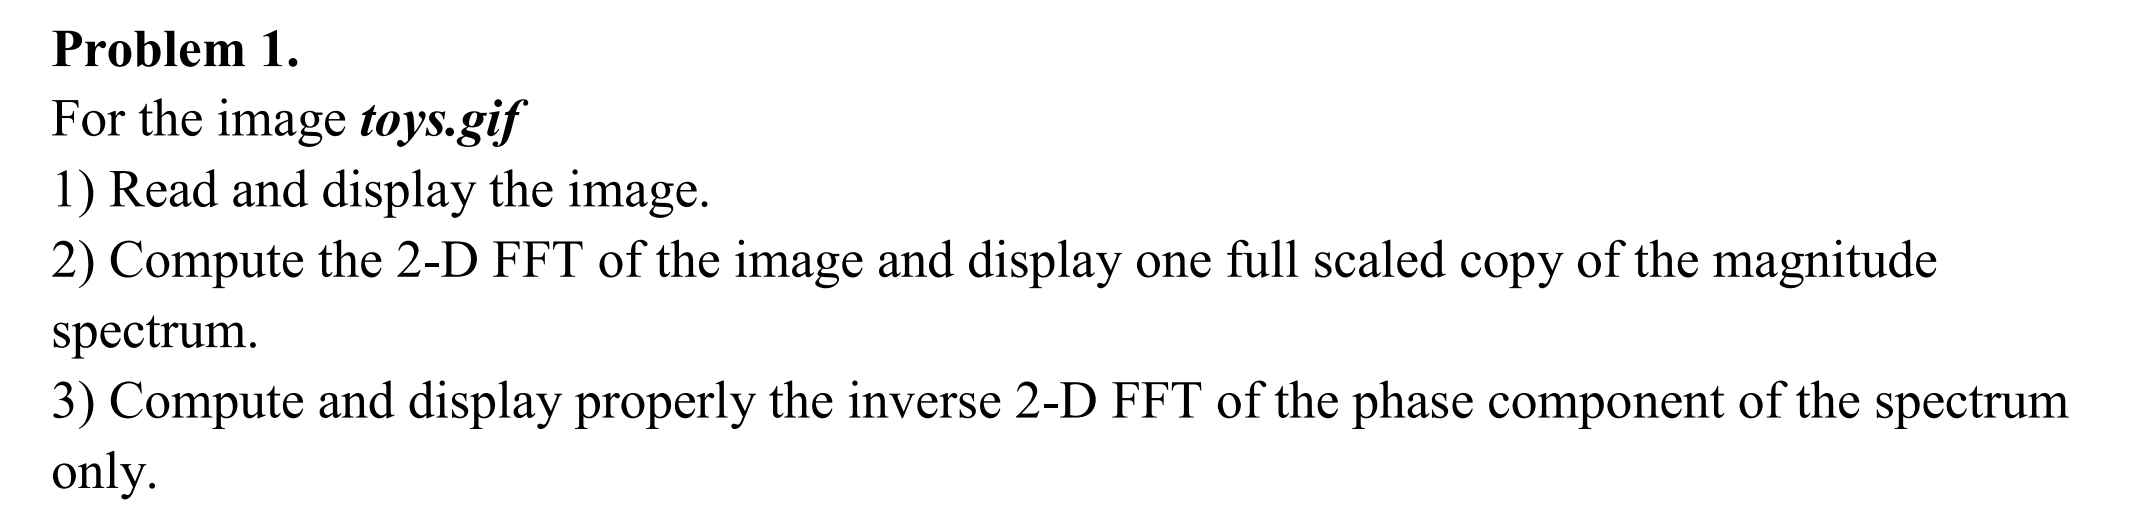

## 1.1

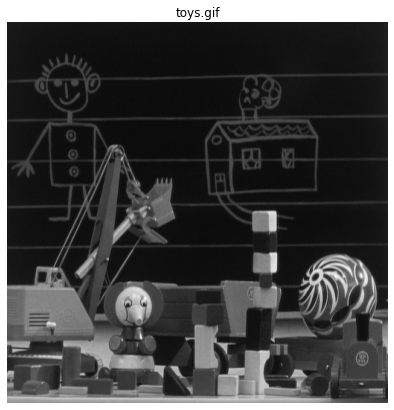

In [8]:
image_name = 'toys.gif'
image = Image.open(image_name)
plot_figure([image], [image_name], 1, 1)

## 1.2

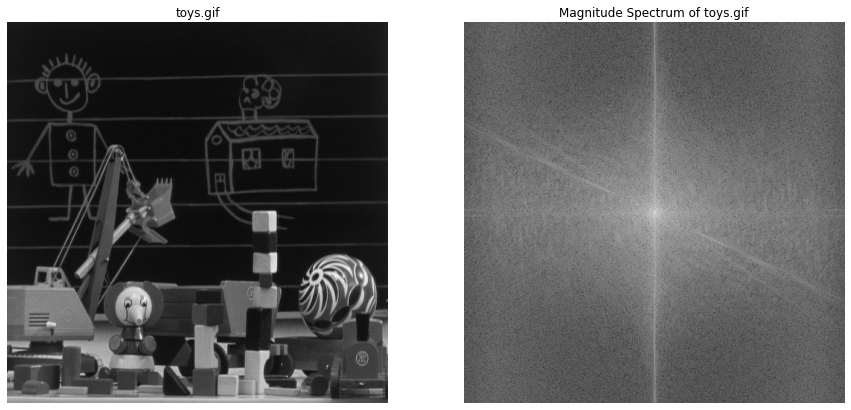

In [9]:
fourier_transform = np.fft.fft2(image)
center_shift = np.fft.fftshift(fourier_transform)
magnitude_spectrum = display_freq(center_shift)
plot_figure([image, magnitude_spectrum], [image_name, f'Magnitude Spectrum of {image_name}'], 1, 2)

OpenCV provides the functions **cv.dft()** and **cv.idft()** for this. It returns the same result as previous, but with two channels. First channel will have the real part of the result and second channel will have the imaginary part of the result. The input image should be converted to np.float32 first.

## 1.3

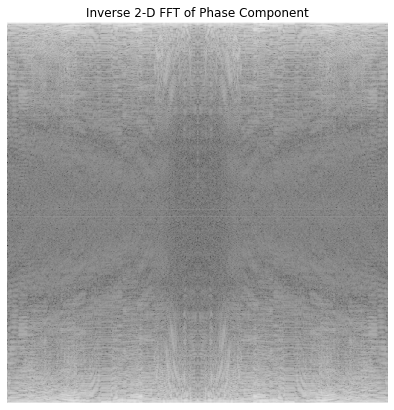

In [10]:
phase = cv2.idft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT)  # phase
ifft_phase = np.fft.ifft(phase)
plot_figure([display_freq(ifft_phase)], [f'Inverse 2-D FFT of Phase Component'], 1, 1)

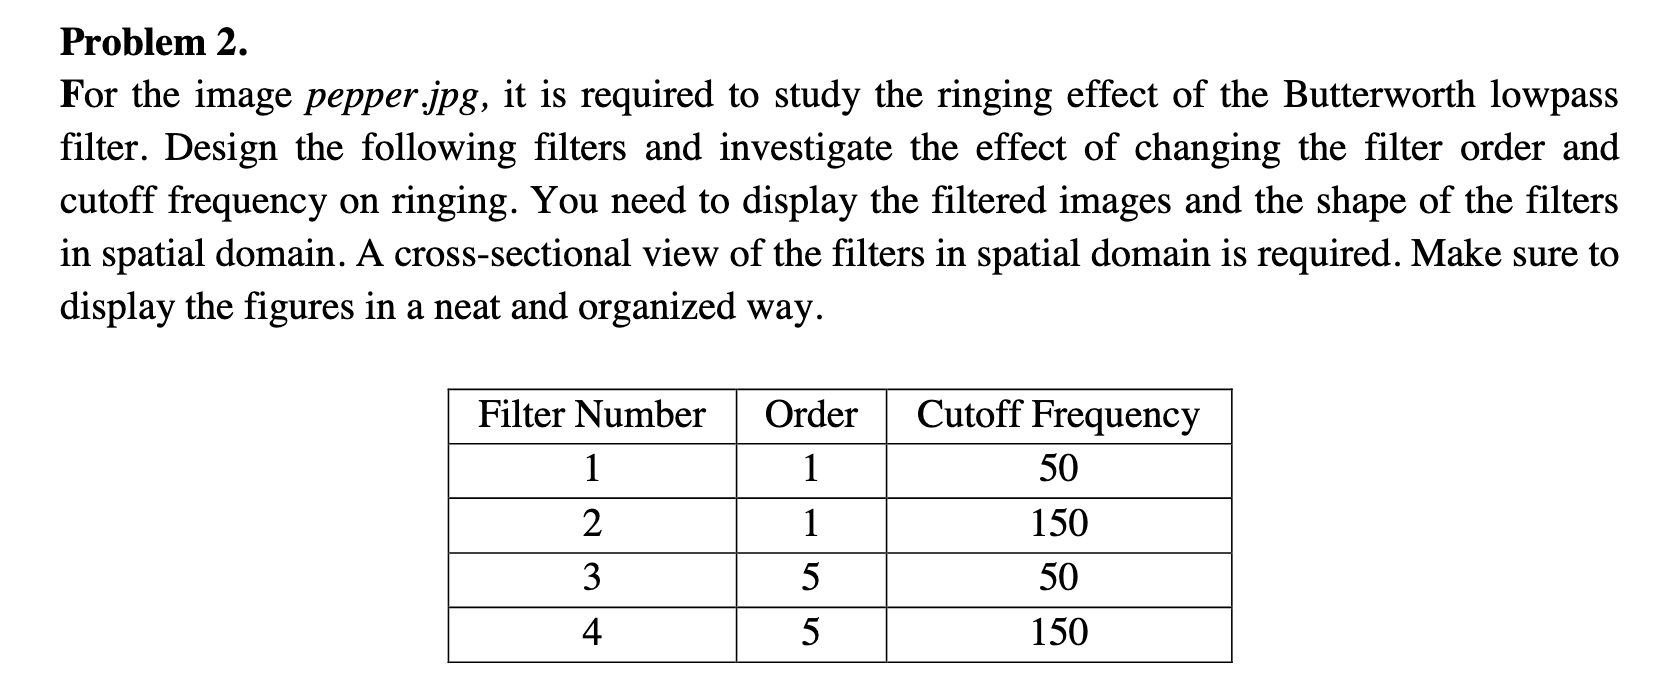

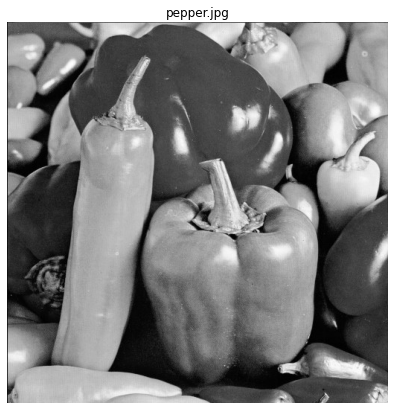

In [11]:
image_name = 'pepper.jpg'
image = cv2.imread(image_name, 0)
plot_figure([image], [image_name], 1, 1)

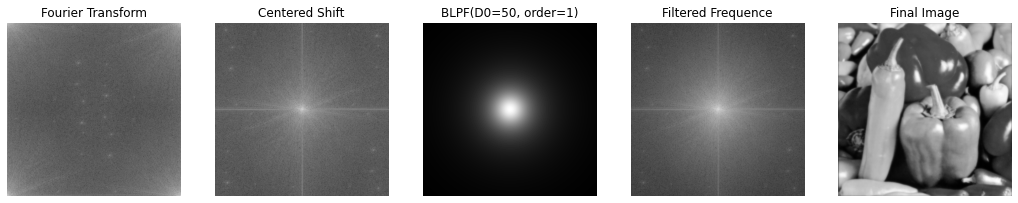

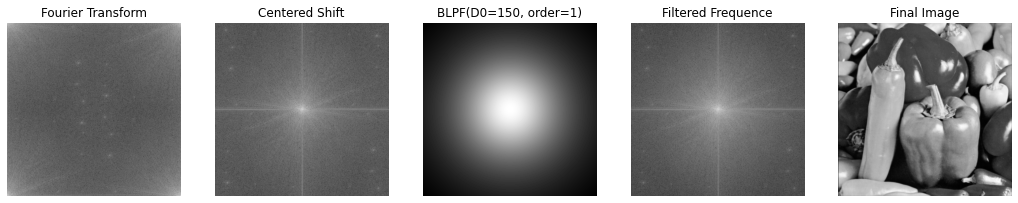

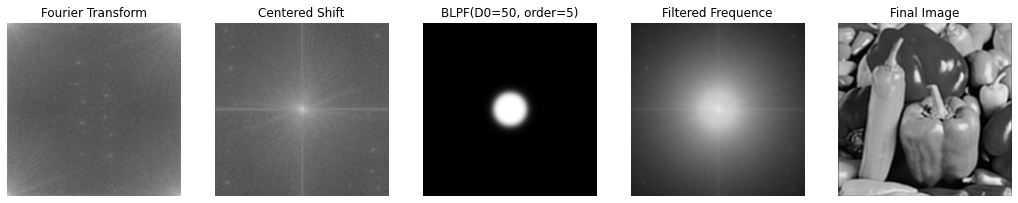

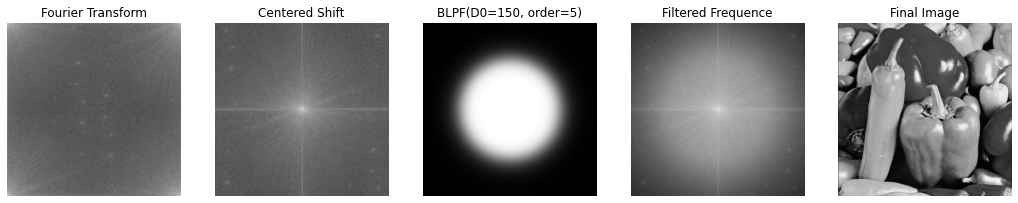

In [12]:
fourier_transform = np.fft.fft2(image)
center_shift = np.fft.fftshift(fourier_transform)

for order, cutoff_frequency in zip([1, 1, 5, 5], [50, 150, 50, 150]):
    blpf = butterworth_lowpass(cutoff_frequency, image.shape, order)
    filtered = center_shift * blpf
    ifftshift_filtered = np.fft.ifftshift(filtered)
    final_image = abs(np.fft.ifft2(ifftshift_filtered))
    plot_figure(
        [display_freq(fourier_transform), display_freq(center_shift), blpf, display_freq(filtered), final_image],
        ['Fourier Transform', 'Centered Shift', f'BLPF(D0={cutoff_frequency}, order={order})',\
         'Filtered Frequence', 'Final Image'],
        1, 5, 18, 12
    )

Ringing increases as a function of filter order.

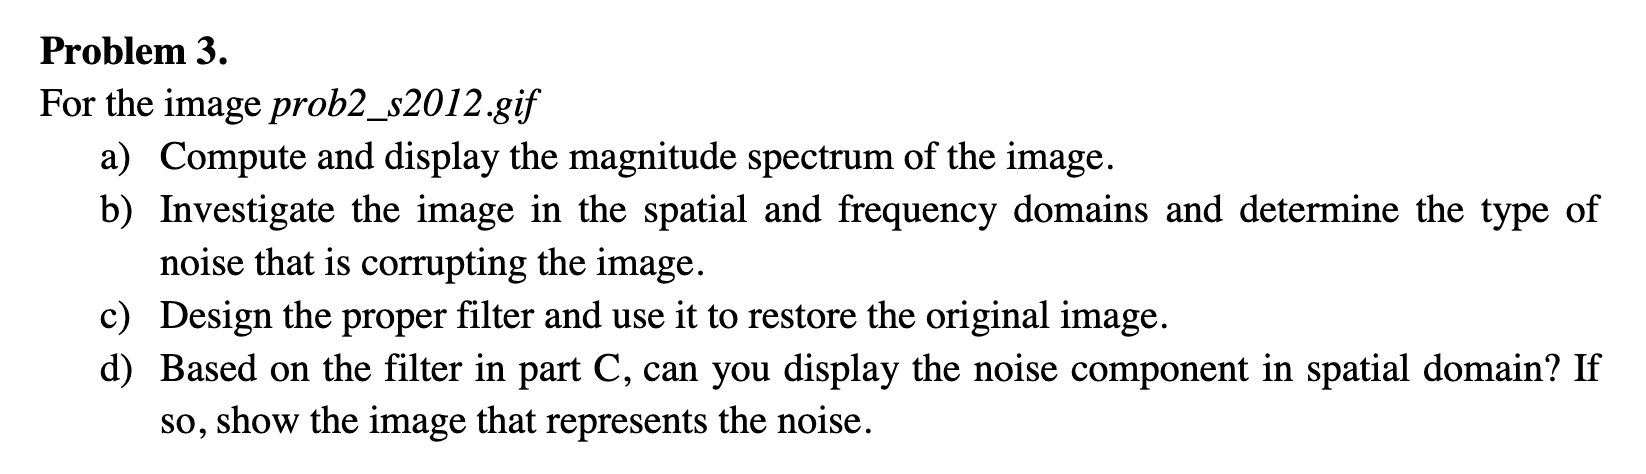

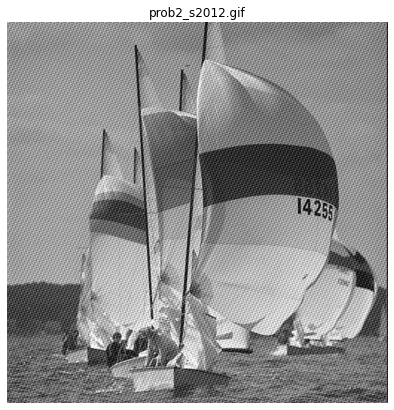

In [13]:
image_name = 'prob2_s2012.gif'
image = Image.open(image_name)
plot_figure([image], [image_name], 1, 1)

## 3.a

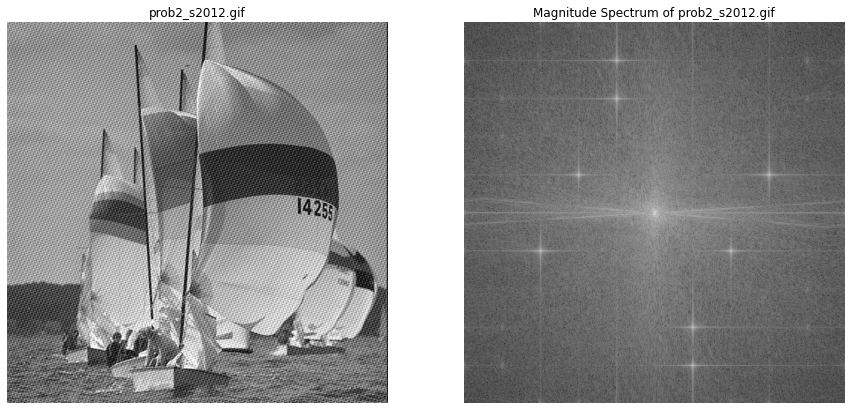

In [14]:
fourier_transform = np.fft.fft2(image)
center_shift = np.fft.fftshift(fourier_transform)
magnitude_spectrum = display_freq(center_shift)
plot_figure([image, magnitude_spectrum], [image_name, f'Magnitude Spectrum of {image_name}'], 1, 2)

## 3.b

**periodic noise** is an unwanted signal that interferes with the source image or signal at a random frequency, depending on its source. Generally, this interference can be added to the image from nature, the electricity network, or electronics devices. Frequency domain techniques in the Fourier domain are the most effective at removing periodic noise.

## 3.c

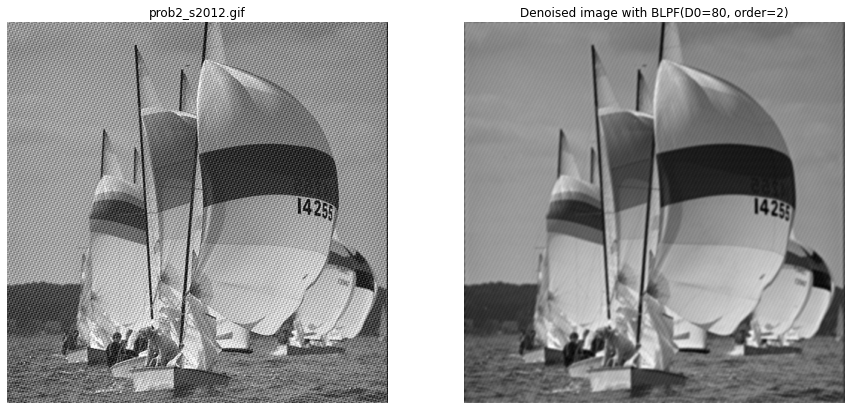

In [15]:
cutoff_frequency, order = 80, 2

blpf = butterworth_lowpass(cutoff_frequency, (image.height, image.width), order)
filtered = center_shift * blpf
ifftshift_filtered = np.fft.ifftshift(filtered)
final_image = abs(np.fft.ifft2(ifftshift_filtered))

plot_figure([image, final_image],
            [image_name, f'Denoised image with BLPF(D0={cutoff_frequency}, order={order})'], 1, 2)

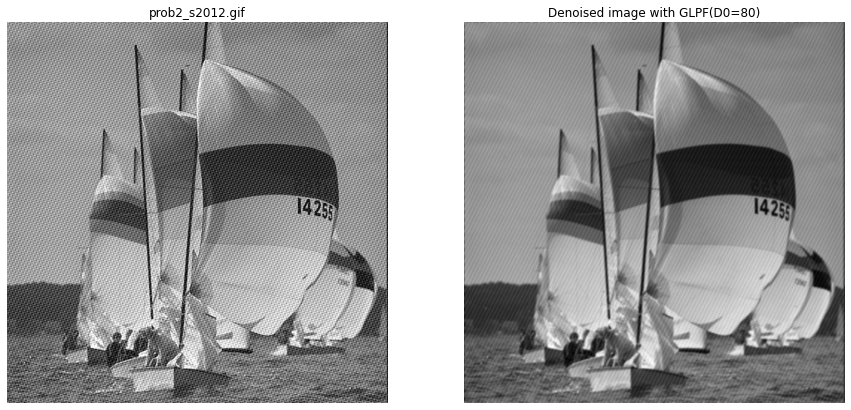

In [16]:
cutoff_frequency = 80

glpf = gaussian_lowpass(cutoff_frequency, (image.height, image.width))
filtered = center_shift * glpf
ifftshift_filtered = np.fft.ifftshift(filtered)
final_image = abs(np.fft.ifft2(ifftshift_filtered))

plot_figure([image, final_image],
            [image_name, f'Denoised image with GLPF(D0={cutoff_frequency})'], 1, 2)

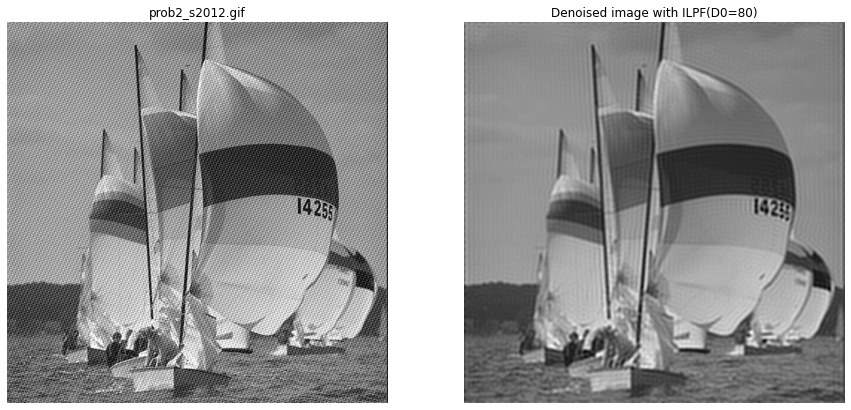

In [17]:
cutoff_frequency = 80

ilpf = ideal_lowpass(cutoff_frequency, (image.height, image.width))
filtered = center_shift * ilpf
ifftshift_filtered = np.fft.ifftshift(filtered)
final_image = abs(np.fft.ifft2(ifftshift_filtered))

plot_figure([image, final_image],
            [image_name, f'Denoised image with ILPF(D0={cutoff_frequency})'], 1, 2)

It seems that the **Butterworth Low-Pass Filter** could reduce the periodic noise better than other two filters. **Gaussian Low-Pass Filter** also did a very better job than the **Ideal Low-Pass Filter**. Ringing artifacts on denoised image using **Ideal Low-Pass Filter** are the side-effects of this filter.

## 3.d

**Noise** is often high frequency in nature. In most images, the high frequency components relatively contain more noise. So I used Gaussian High-Pass Filter for passing the high frequencies of the image and extracting noise of the image.

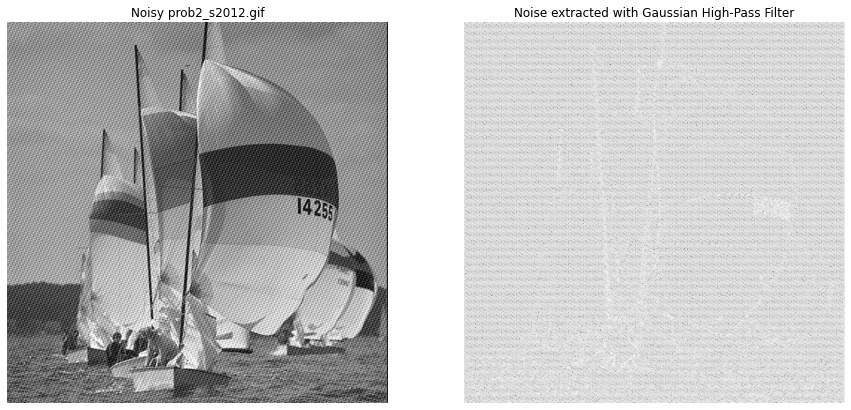

In [18]:
cutoff_frequency = 80

glpf = gaussian_lowpass(cutoff_frequency, (image.height, image.width))
filtered = center_shift * (1-glpf)
ifftshift_filtered = np.fft.ifftshift(filtered)
final_image = np.fft.ifft2(ifftshift_filtered)

plot_figure([image, display_freq(final_image)],
            [f'Noisy {image_name}', f'Noise extracted with Gaussian High-Pass Filter'], 1, 2)

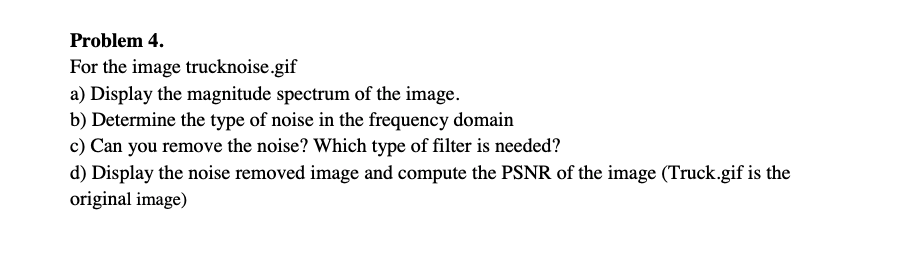

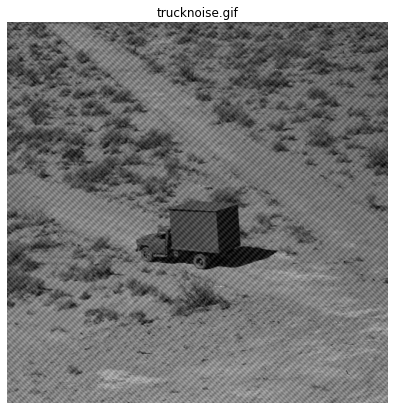

In [19]:
image_name = 'trucknoise.gif'
image = Image.open(image_name)
plot_figure([image], [image_name], 1, 1)

## 4.a

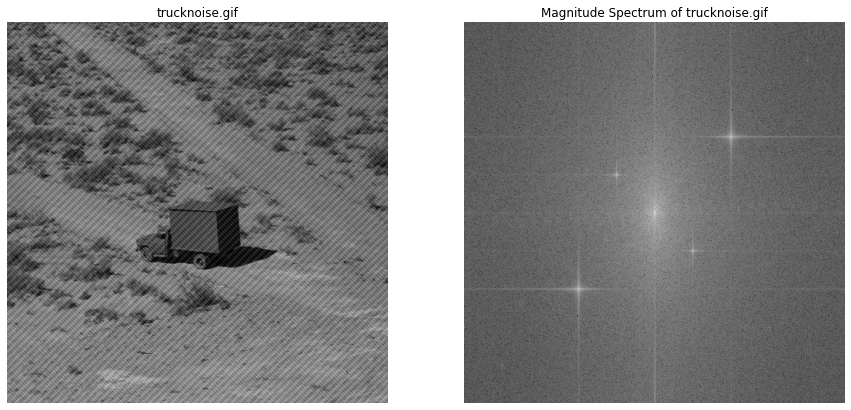

In [20]:
fourier_transform = np.fft.fft2(image)
center_shift = np.fft.fftshift(fourier_transform)
magnitude_spectrum = display_freq(center_shift)
plot_figure([image, magnitude_spectrum], [image_name, f'Magnitude Spectrum of {image_name}'], 1, 2)

## 4.b

**Periodic Noise**

## 4.c

The **Periodic** noise can be reduced or removed with **Frequency Domain Filters**.

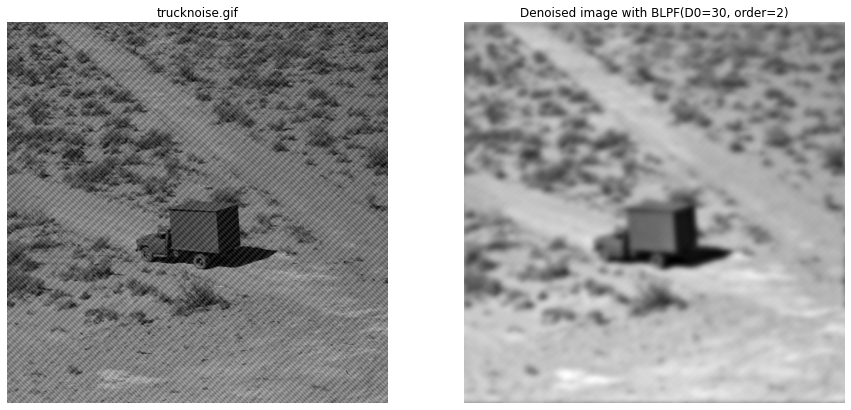

In [21]:
cutoff_frequency, order = 30, 2

blpf = butterworth_lowpass(cutoff_frequency, (image.height, image.width), order)
filtered = center_shift * blpf
ifftshift_filtered = np.fft.ifftshift(filtered)
final_image = abs(np.fft.ifft2(ifftshift_filtered))

plot_figure([image, final_image],
            [image_name, f'Denoised image with BLPF(D0={cutoff_frequency}, order={order})'], 1, 2)

## 4.d

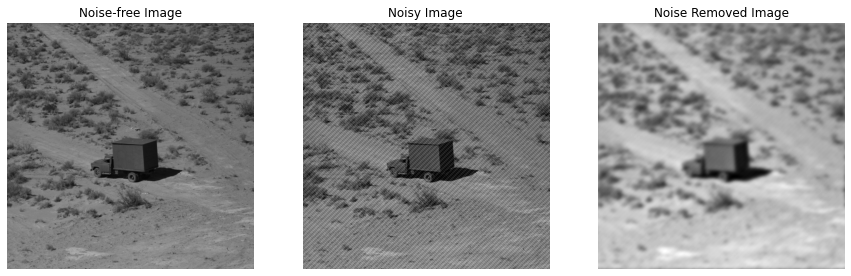

In [22]:
noise_free_image_name = 'truck.gif'
noise_free_image = np.array(Image.open(noise_free_image_name), dtype=np.float64)

plot_figure([noise_free_image, image, final_image],
            ['Noise-free Image', 'Noisy Image', f'Noise Removed Image'], 1, 3)

The **PSNR** block computes the peak signal-to-noise ratio, in decibels, between two images. This ratio is used as a quality measurement between the original and a compressed image. The higher the **PSNR**, the better the quality of the compressed, or reconstructed image.

In [23]:
cv2.PSNR(noise_free_image, final_image)

27.29587828488018